# Imports

In [1685]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1687]:
# Pandas and numpy
import pandas as pd
import numpy as np

# Libraries for Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from src.visualization.visualize import plot_corr_matrix, plot_multi, plot_norm_dist, plot_feature_importances

# Some custom tools
from src.data.tools import check_for_missing_vals

# Alpaca API
import alpaca_trade_api as tradeapi

# Pickle
import pickle
import os
from pathlib import Path

# To load variables from .env file into system environment
from dotenv import find_dotenv, load_dotenv

from atomm.Indicators import MomentumIndicators
from atomm.DataManager.main import MSDataManager
from src.visualization.visualize import plot_confusion_matrix
from atomm.Tools import calc_open_position


# Feature building tool
from src.features.build_features import calcIndicators


In [1688]:
# Load environment variables
load_dotenv(find_dotenv())

True

# Loading the data

In [1689]:
fname = os.path.join(data_base_dir, 'processed', 'index.h5')
fname = Path(fname)
with pd.HDFStore(fname) as storage:
    djia = storage.get('nyse/cleaned/rand_symbols')

In [912]:
# Load dataset from pickle file
data_base_dir = os.environ.get('DATA_DIR_BASE_PATH')
fname = data_base_dir + '/processed/djia_cleaned_2019-12-11.pkl'
djia = pickle.load(open(fname, 'rb'))

In [1690]:
symbol_list = djia.columns.get_level_values(0).unique()

In [1691]:
forecast_horizon = [1, 3, 5, 7, 10, 15, 20, 25, 30]
input_window_size = [3, 5, 7, 10, 15, 20, 25, 30]

In [1708]:
symbol_list

Index(['CNC', 'FMC', 'ALGN', 'RTN', 'FAST', 'ETFC', 'ABC', 'PFG', 'AXP', 'PNW',
       'CMS', 'URI', 'PRGO', 'DRI', 'MAS', 'M', 'ZION', 'CINF', 'HIG', 'EOG',
       'ICE', 'CBOE', 'ALL', 'UHS', 'FRT', 'NEM', 'BLL', 'NDAQ', 'CMG', 'JKHY',
       'T', 'QCOM', 'FTI', 'AOS', 'ATVI', 'STT', 'TXN', 'KIM', 'NTAP', 'CHD',
       'WYNN', 'GM', 'SJM', 'MCHP', 'ES', 'KMB', 'GIS', 'EXC', 'IBM', 'MSFT'],
      dtype='object')

# Target variable

## Forecast Horizon

The target of this project is to forecast future price movements of a given asset based on the different technical indicators. Technical indicators are mathematical formulas intended which reflect the past price movements. It is assumed that history will (at least partially) be repeated in the future.

In order to build a supervised machine learning model, we need a target variable. Here, we will use two different classifications for predicting the future price trend: A two label classification scheme (1: up, 0: down), and a three label classification scheme (1: up; 0: no movement; -1: down). In both cases, the relative future price change is used to label the training and test data set:
$$y(t)=\frac{C_{t+n}-C_t}{C_t}$$


## Two-class classification

For the two label classification, the labels are calculated as follows

$$l(t)=\begin{cases}1, & \text{if $ y(t)\gt 0$ }\\0, & \text{if $ y(t)\lt 0$ } \\\end{cases}$$

In [1031]:
 for n in forecast_horizon:
            #diff = (data['Close'].shift(-n) - data['Close'])/data['Close']
            #signal = np.where(diff > 0, 1, 0)
            dicti['CNC'][f'_signal_{n}'] = 1

In [1696]:
def create_two_class_signal(df, symbol_list):
    df_signals = pd.DataFrame(pd.MultiIndex.from_product([[], []]),)# index=df.index)
    sign_dic = {}
    for symbol in symbol_list:
        data = df[symbol]
        dicti = {}
        for n in forecast_horizon:
            diff = (data['Close'].shift(-n) - data['Close'])/data['Close']
            signal = np.where(diff > 0, 1, 0)
            dicti[f'signal_{n}'] = signal
        sign_df = pd.DataFrame.from_dict(dicti)
        sign_dic[symbol] = sign_df
    df_signals = pd.concat(sign_dic.values(), keys=sign_dic.keys(), axis=1)
    return df_signals

In [1697]:
#dicti = {}
y_2c = create_two_class_signal(djia, symbol_list)

Some NaNs, most of them are probably due to the fact
Drop the first x days of X, where is the maximum lookback window size

In [1694]:
# Remove first and last 30 entries
y_2c = y_2c[max(input_window_size):-max(forecast_horizon)]

In [1698]:
y_2c.shape

(1954, 450)

### Is data balanced?

Calculate percentage of data points assigned to each class

In [1700]:
l1 = []
for y in y_2c.columns.get_level_values(0).unique():
    l = []
    for x in y_2c[y].columns:
        c = y_2c[y][x].value_counts()
        s = c[0] + c[1]
        l.append([c[0]/s, c[1]/s])
    l1.append(l)
pd.DataFrame(np.mean(np.array(l1), axis=0).T, index=pd.Index(['0', '1']), columns=y_2c.columns.get_level_values(1).unique())

,signal_1,signal_3,signal_5,signal_7,signal_10,signal_15,signal_20,signal_25,signal_30
0,0.475722,0.459754,0.452446,0.448495,0.441945,0.434381,0.429806,0.4248,0.420082
1,0.524278,0.540246,0.547554,0.551505,0.558055,0.565619,0.570194,0.5752,0.579918


### Plot signals and open positions

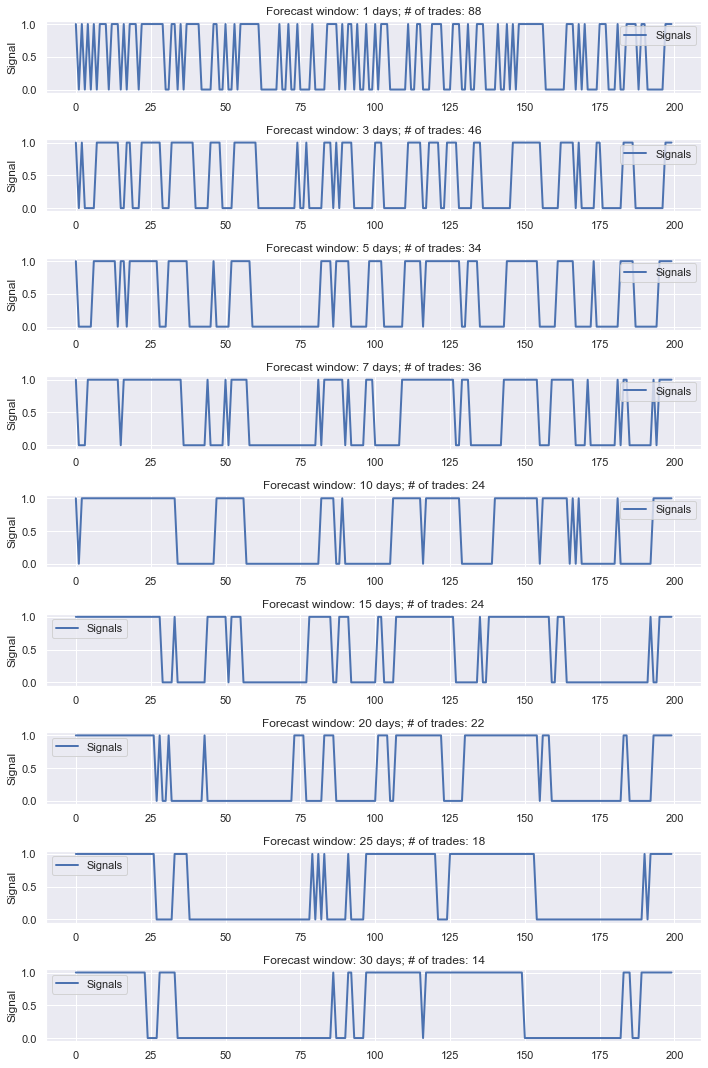

In [1706]:
plt.figure(figsize=(10, 15))
colors = ['black', 'red', 'green', 'blue']
window = 200
symbol = 'IBM'
for i, n in enumerate(forecast_horizon):
    plt.subplot(len(input_n), 1, i+1)
    plt.plot(y_2c[symbol][f'signal_{n}'][:window], lw=2, label='Signals')
    #plt.plot(y_3c[f'AAPL_open_position_{n}'][:window], label='Open Position', lw=2,)
    plt.legend()
    plt.tight_layout()
    plt.ylabel('Signal')
    num_of_trades = int(y_2c[symbol][f'signal_{n}'][:window].diff().abs().sum())
    plt.title(f'Forecast window: {n} days; # of trades: {num_of_trades}')
plt.show()

## Three class classification

For the three class classification, the labels are calculated as follows

$$l(t)=\begin{cases}1, & \text{if $ y(t)\gt \delta$ }\\0, & \text{if $-\delta \leq y(t)\leq \delta$ } \\-1, & \text{if $ y(t)\lt -\delta$ }\end{cases}$$

where the threshold $\delta$ is a parameter of the strategy that needs tuning.

In [1702]:
threshold_list = [0.63, 1.15, 1.49, 1.79, 2.14, 2.65, 3.08, 3.48, 3.94]

In [1703]:
def create_three_class_signal(df, symbol_list, threshold=None, multi=1):
    df_signals = pd.DataFrame(pd.MultiIndex.from_product([[], []]),)# index=df.index)
    df_op = df_signals.copy()
    sign_dic, op_dic = {}, {}
    for symbol in symbol_list:
        data = df[symbol]
        dicti, dict_op = {}, {}
        for n, thresh in zip(forecast_horizon, threshold):
            diff = (data['Close'].shift(-n) - data['Close'])/data['Close']
            signal1p = np.where(diff > multi*thresh/100, 1, 0)
            signal1n = np.where(diff < -multi*thresh/100, -1, 0)
            signal = signal1p + signal1n
            open_position = calc_open_position(signal)
            dicti[f'signal_{n}'] = signal
            dict_op[f'open_position_{n}'] = open_position
        sign_dic[symbol] = pd.DataFrame.from_dict(dicti)
        op_dic[symbol] = pd.DataFrame.from_dict(dict_op)
    df_signals = pd.concat(sign_dic.values(), keys=sign_dic.keys(), axis=1)
    df_op = pd.concat(op_dic.values(), keys=op_dic.keys(), axis=1)
    return df_signals, df_op

In [1711]:
#%%timeit

sym_list = symbol_list[:]

#dicti = {}
y_3c, y_3op = create_three_class_signal(djia, sym_list, threshold=threshold_list)
y_3c_test, y_3op_test = create_three_class_signal(djia, sym_list, threshold=threshold_list)

# Remove first and last 30 entries
#y_3c = y_3c[max(input_window_size):-max(forecast_horizon)]
#y_3op = y_3op[max(input_window_size):-max(forecast_horizon)]

In [1712]:
y_3c.shape, y_3op.shape

((1954, 450), (1954, 450))

### Calculate percentage of data points assigned to each class

In [1713]:
l1 = []
for y in y_3c.columns.get_level_values(0).unique():
    l = []
    for x in y_3c[y].columns:
        c = y_3c[y][x].value_counts()
        s = c[0] + c[1] + c[-1]
        l.append([c[-1]/s, c[0]/s, c[1]/s])
    l1.append(l)
pd.DataFrame(np.mean(np.array(l1), axis=0).T, index=pd.Index(['-1', '0', '1']), columns=y_3c.columns.get_level_values(1).unique())

,signal_1,signal_3,signal_5,signal_7,signal_10,signal_15,signal_20,signal_25,signal_30
-1,0.267503,0.256233,0.253808,0.249611,0.244289,0.238895,0.235343,0.230368,0.220338
0,0.424023,0.427830,0.418813,0.420215,0.417605,0.414033,0.408188,0.406991,0.419007
1,0.308475,0.315937,0.327380,0.330174,0.338106,0.347073,0.356469,0.362641,0.360655


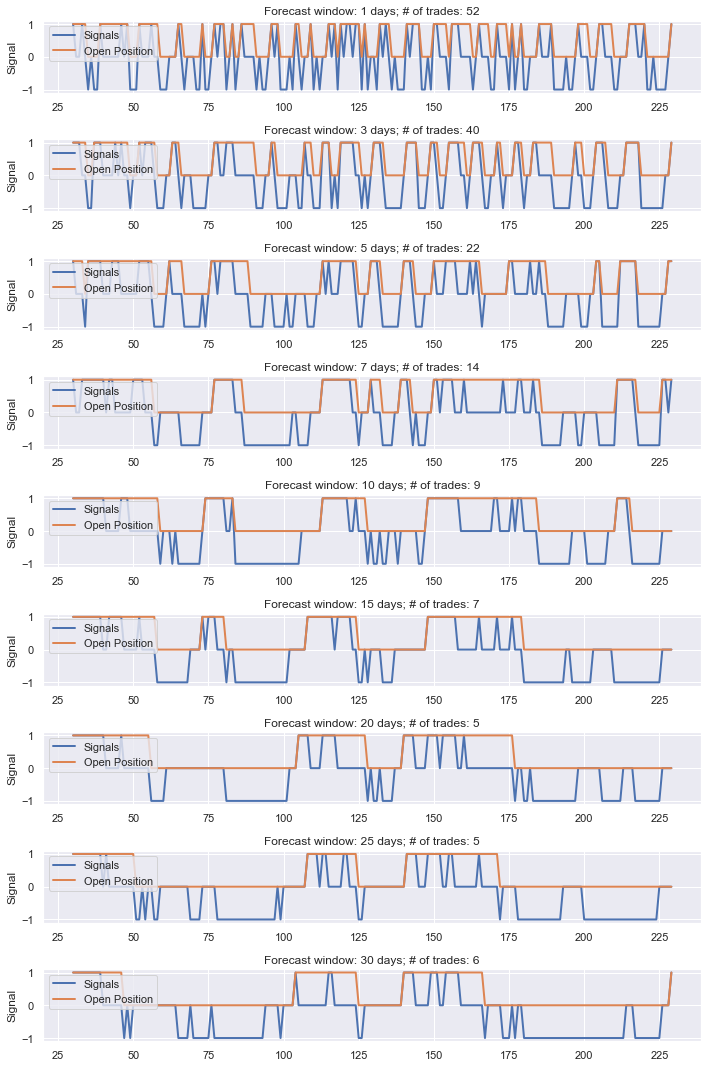

In [1565]:
plt.figure(figsize=(10, 15))
colors = ['black', 'red', 'green', 'blue']
window = 200
symbol = 'MSFT'
for i, n in enumerate(input_n):
    plt.subplot(len(input_n), 1, i+1)
    plt.plot(y_3c[symbol][f'signal_{n}'][:window], lw=2, label='Signals')
    plt.plot(y_3op[symbol][f'open_position_{n}'][:window], label='Open Position', lw=2,)
    plt.legend()
    plt.tight_layout()
    plt.ylabel('Signal')
    num_of_trades = int(y_3op[symbol][f'open_position_{n}'][:window].diff().abs().sum())
    plt.title(f'Forecast window: {n} days; # of trades: {num_of_trades}')
plt.show()

# Feature Engineering

Input window length:
[3, 5, 7, 10, 15, 20, 25, 30]

1. MACD x
2. RSI x
3. ROC x
4. BB x
5. SMA x
6. EMA x
7. ATR x
8. ADX x
9. CCI x
10. WILLIAMSR x
11. STOCK_n x
12. STOCD EMA_n(STOCK) x

In [1731]:
ti_list = ['sma', 'rsi', 'stoc', 'roc', 'ema', 'atr', 'adx', 'cci', 'williamsr', 'stocd', 'log_ret', \
           'autocorr_1', 'autocorr_3', 'autocorr_5', 'vol']+['macd','rsi', 'stoc', 'roc', 'bbu', 'bbl',\
            'ema', 'atr', 'adx', 'cci', 'williamsr', 'stocd']+['sma', 'rsi', 'stoc', 'roc', 'ema', 'atr',\
                                                               'adx', 'cci', 'williamsr', 'stocd']
ti_list = list(set(ti_list))
ti_list = ['stoc',
 'atr',
 'williamsr',
 'cci',
 'rsi',
 'log_ret',
 'adx',
 'macd',
 'roc',
 'vol',
 'ema',
 'bb',
 'stocd',
 'sma',
 'autocorr_1',
 'autocorr_3',
'autocorr_5']

In [1732]:
input_window_size = [3, 5, 7, 10, 15, 20, 25, 30]
mom_dict = {}

cnt = 1
start = time.time()
total = len(symbol_list)
for symbol in symbol_list:
    res = calcIndicators(djia, symbol, input_window_size, ti_list)
    mom_dict[symbol] = res
    clear_output(wait=True)
    display(f'Leg [{cnt} / {total}]; Last symbol: {symbol}; Elapsed time: {round(time.time()-start, 0)}s')
    cnt += 1
    
df_moments = pd.concat(mom_dict.values(), keys=mom_dict.keys(), axis=1)

'Leg [50 / 50]; Last symbol: MSFT; Elapsed time: 1786.0s'

Remove first and last 30 entries for the momentum indicator dataframe

In [1600]:
df_moments = df_moments.iloc[max(input_window_size):-max(forecast_horizon)]

In [1601]:
df_moments.shape

(1954, 4800)

In [1607]:
np.where(df_moments.isna())

(array([  17,  368,  497, 1302, 1758, 1924]),
 array([ 578,  866, 3266, 2306, 1442, 2882]))

In [1612]:
df_moments.iloc[1758, :][df_moments.iloc[1758, :].isna()]

M  stoc_3   NaN
Name: 2019-01-30 00:00:00+00:00, dtype: float64

In [1605]:
sum(df_moments.isna().sum())

6

Computing the technical indicators resulted in NaNs in 6 cases, all of which occurred for STOC indicator and time window 3. We will interpolate missing values for now.

In [1613]:
df_moments = df_moments.interpolate(limit=1)

In [1614]:
sum(df_moments.isna().sum())

0

Remove first and last 30 entries for the djia dataframe

In [1629]:
djia = djia.iloc[max(input_window_size):-max(forecast_horizon)]

In [1630]:
djia.shape

(1954, 250)

## Visualizing the technical indicators

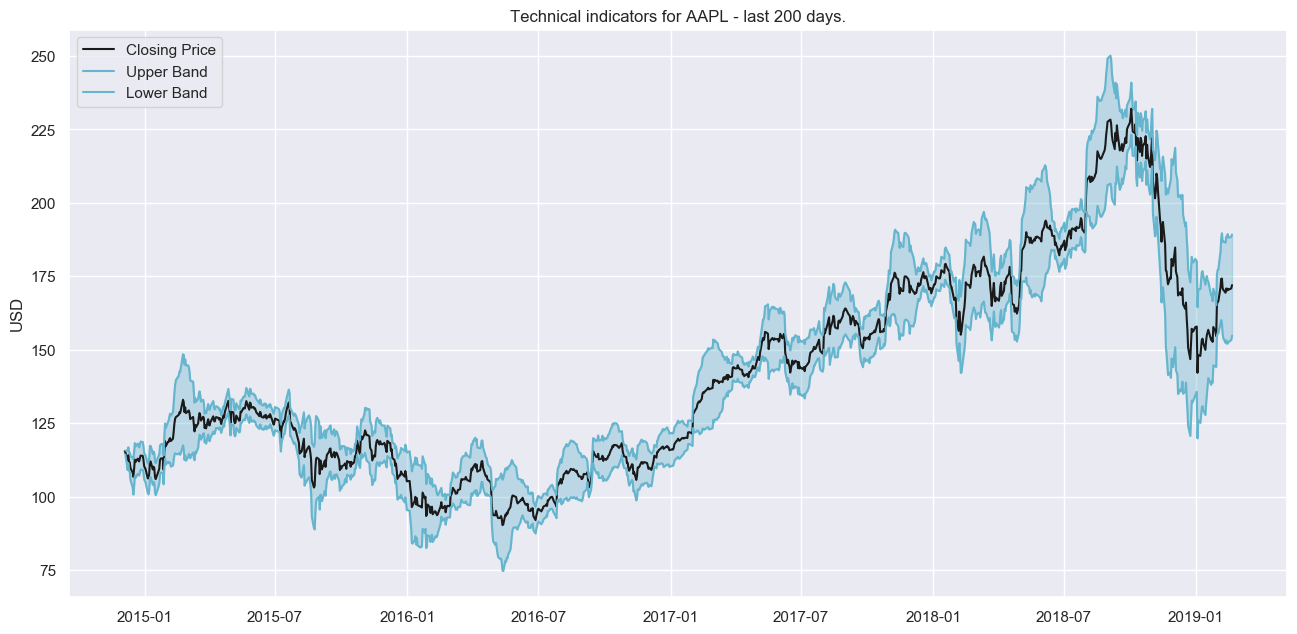

In [934]:
symbol = 'AAPL'

x_ = range(3, X.shape[0])
x_ = list(X.index)

last_days = 200
n = 30
#plt.fill_between()
plt.figure(figsize=(14, 7), dpi=100)
#plt.plot(dataset['ma7'], label='MA 7', color='g',linestyle='--')
plt.plot(djia[symbol]['Close'][:-last_days], label='Closing Price', color='k')
#plt.plot(X[symbol+'_macd1'],label='MACD 12, 26', color='r',linestyle='--')
plt.plot(X[f'{symbol}_bbu_{n}'][:-last_days], label='Upper Band', color='c')
plt.plot(X[f'{symbol}_bbl_{n}'][:-last_days], label='Lower Band', color='c')
plt.fill_between(X.index[:-last_days], X[f'{symbol}_bbu_{n}'][:-last_days], X[f'{symbol}_bbl_{n}'][:-last_days], color='c', alpha=0.35)
plt.title(f'Technical indicators for {symbol} - last {last_days} days.')
plt.ylabel('USD')
plt.legend()

In [476]:
#sns.pairplot(X.fillna(0))

In [477]:
X.fillna(0, inplace=True)

# Store data 

In [996]:
data_base_dir = os.environ.get('DATA_DIR_BASE_PATH')
fname1 = data_base_dir + '/processed/djia_features_2019-12-19.pkl'
pickle.dump(X , open(fname1, 'wb'))

fname2 = data_base_dir + '/processed/djia_target_y_2c_2019-12-19.pkl'
pickle.dump(y_3c, open(fname2, 'wb'))

fname3 = data_base_dir + '/processed/djia_target_y_3c_2019-12-19.pkl'
pickle.dump(y_3c, open(fname3, 'wb'))

In [1631]:
with pd.HDFStore(fname) as storage:
    storage.put('nyse/cleaned/rand_symbols', djia)
    storage.put('nyse/engineered/target_two_class', y_2c)
    storage.put('nyse/engineered/target_three_class', y_3c)
    storage.put('nyse/engineered/features', df_moments)
    print(storage.info())


<class 'pandas.io.pytables.HDFStore'>
File path: /Users/robin/Documents/nf-ds/capstone_nf/data/processed/index.h5
/nyse/cleaned/rand_symbols                     frame
/nyse/engineered/features                      frame
/nyse/engineered/target_three_class            frame
/nyse/engineered/target_two_class              frame
/nyse/prices                                   frame
/nyse/rand_symbols                             frame
/nyse/raw/rand_symbols                         frame


In [939]:
import pandas_datareader.famafrench
from pandas_datareader.famafrench import get_available_datasets
get_available_datasets()

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily',
 'Portfolios_Formed_on_ME',
 'Portfolios_Formed_on_ME_Wout_Div',
 'Portfolios_Formed_on_ME_Daily',
 'Portfolios_Formed_on_BE-ME',
 'Portfolios_Formed_on_BE-ME_Wout_Div',
 'Portfolios_Formed_on_BE-ME_Daily',
 'Portfolios_Formed_on_OP',
 'Portfolios_Formed_on_OP_Wout_Div',
 'Portfolios_Formed_on_INV',
 'Portfolios_Formed_on_INV_Wout_Div',
 '6_Portfolios_2x3',
 '6_Portfolios_2x3_Wout_Div',
 '6_Portfolios_2x3_weekly',
 '6_Portfolios_2x3_daily',
 '25_Portfolios_5x5',
 '25_Portfolios_5x5_Wout_Div',
 '25_Portfolios_5x5_Daily',
 '100_Portfolios_10x10',
 '100_Portfolios_10x10_Wout_Div',
 '100_Portfolios_10x10_Daily',
 '6_Portfolios_ME_OP_2x3',
 '6_Portfolios_ME_OP_2x3_Wout_Div',
 '6_Portfolios_ME_OP_2x3_daily',
 '25_Portfolios_ME_OP_5x5',
 '25_Portfolios_ME_OP_5x5_Wout_Div',
 '25_Portfolios_ME_OP_5x5_daily',
 '100_Po

In [942]:
from pandas_datareader.famafrench import FamaFrenchReader

In [943]:
ffr = FamaFrenchReader(['AAPL'])

In [949]:
import pandas_datareader as web

In [950]:
ds = web.DataReader('5_Industry_Portfolios', 'famafrench')


In [957]:
print(ds['DESCR'])

5 Industry Portfolios
---------------------

This file was created by CMPT_IND_RETS using the 201910 CRSP database. It contains value- and equal-weighted returns for 5 industry portfolios. The portfolios are constructed at the end of June. The annual returns are from January to December. Missing data are indicated by -99.99 or -999. Copyright 2019 Kenneth R. French

  0 : Average Value Weighted Returns -- Monthly (59 rows x 5 cols)
  1 : Average Equal Weighted Returns -- Monthly (59 rows x 5 cols)
  2 : Average Value Weighted Returns -- Annual (5 rows x 5 cols)
  3 : Average Equal Weighted Returns -- Annual (5 rows x 5 cols)
  4 : Number of Firms in Portfolios (59 rows x 5 cols)
  5 : Average Firm Size (59 rows x 5 cols)
  6 : Sum of BE / Sum of ME (6 rows x 5 cols)
  7 : Value-Weighted Average of BE/ME (6 rows x 5 cols)


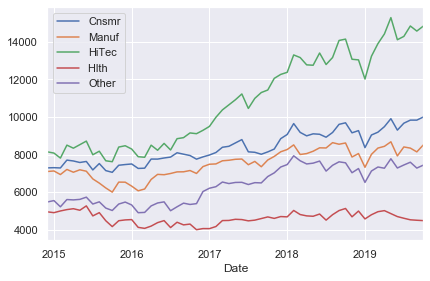

In [960]:
ds[5].plot()

In [961]:
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols
symbols = get_nasdaq_symbols()


In [966]:
symbols.loc['AAPL']

Nasdaq Traded                            True
Security Name       Apple Inc. - Common Stock
Listing Exchange                            Q
Market Category                             Q
ETF                                     False
Round Lot Size                            100
Test Issue                              False
Financial Status                            N
CQS Symbol                                NaN
NASDAQ Symbol                            AAPL
NextShares                              False
Name: AAPL, dtype: object

In [977]:
f = web.DataReader('^SPX', 'stooq')

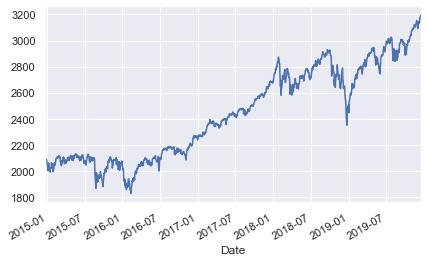

In [978]:
f['Close'].plot()

In [986]:
from pathlib import Path


In [982]:
DATA_STORE = Path('test.h5')
with pd.HDFStore(DATA_STORE) as store:
    store.put('engineered_features', X.sort_index())
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: test.h5
/engineered_features            frame        (shape->[1259,96])


In [993]:
%%timeit -o
with pd.HDFStore(DATA_STORE) as store:
    df = store.get('engineered_features')


7.51 ms ± 209 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 7.51 ms ± 209 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [994]:
_

<TimeitResult : 7.51 ms ± 209 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>